<a href="https://colab.research.google.com/github/Biruk-gebru/Causal-Gene-Prediction-and-Validation-with-LLMs/blob/main/Module2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers datasets torch sentencepiece
!pip install fuzzywuzzy python-Levenshtein


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 37.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [7]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("/content/drive/MyDrive/biomed_stage3_contrastive")


In [15]:
!wget -O hgnc_complete_set.tsv \
https://storage.googleapis.com/public-download-files/hgnc/tsv/tsv/hgnc_complete_set.txt


--2025-06-05 11:45:00--  https://storage.googleapis.com/public-download-files/hgnc/tsv/tsv/hgnc_complete_set.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.207, 142.251.12.207, 172.253.118.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16588709 (16M) [text/plain]
Saving to: ‘hgnc_complete_set.tsv’

hgnc_complete_set.t 100%[===================>]  15.82M  4.76MB/s    in 3.3s    

2025-06-05 11:45:06 (4.76 MB/s) - ‘hgnc_complete_set.tsv’ saved [16588709/16588709]



In [16]:
import csv

def load_hgnc_symbols():
    with open("hgnc_complete_set.tsv", "r") as f:
        reader = csv.DictReader(f, delimiter="\t")
        # Confirm that “symbol” is indeed a column
        if "symbol" not in reader.fieldnames:
            raise ValueError(f"Expected 'symbol' column but found: {reader.fieldnames}")
        return set(row["symbol"].upper() for row in reader if row["symbol"].strip())

hgnc_symbols = load_hgnc_symbols()
print(f"Loaded {len(hgnc_symbols)} HGNC symbols.")


Loaded 44105 HGNC symbols.


In [10]:
with open("hgnc_genes.tsv", "r") as f:
    headers = f.readline().strip().split("\t")
    print(headers)


['<!DOCTYPE HTML PUBLIC "-//IETF//DTD HTML 2.0//EN">']


In [20]:
# (A) If hgnc_symbols is not in this session, load it from the TSV you already downloaded:
try:
    hgnc_symbols
except NameError:
    import csv
    def load_hgnc_symbols():
        with open("hgnc_complete_set.tsv", "r") as f:
            reader = csv.DictReader(f, delimiter="\t")
            return set(row["symbol"].upper()
                       for row in reader
                       if row.get("symbol", "").strip())
    hgnc_symbols = load_hgnc_symbols()

# (B) Define a small set of Gene Ontology (GO) terms.
#     You can expand this list later or pull in a larger GO‐term file if desired.
gene_ontology_terms = {
    "apoptosis",
    "angiogenesis",
    "tumor suppression",
    "cell cycle",
    "immune response",
    "signal transduction",
    "gene expression",
    "cell death",
    "dna repair",
    "metabolism",
    "cell proliferation",
    "cell differentiation"
}

# (C) Import fuzzy matching and define the grounding check:
from fuzzywuzzy import fuzz

def is_ontology_grounded(output_text: str,
                        gene_set: set,
                        ontology_set: set,
                        threshold: int = 85) -> dict:
    """
    Check if `output_text` mentions at least one HGNC-approved gene symbol
    and at least one GO term from ontology_set. Returns a dict:
      - 'gene_matches':   list of matched gene symbols (>= threshold)
      - 'ontology_matches': list of matched ontology terms (>= threshold)
      - 'is_grounded':    True iff both gene_matches and ontology_matches non-empty
    """
    out_lower = output_text.lower()
    tokens = out_lower.split()

    # (1) Find gene symbol hits (fuzzy match each token against each symbol)
    gene_hits = [
        gene
        for gene in gene_set
        if any(fuzz.partial_ratio(gene.lower(), tok) >= threshold for tok in tokens)
    ]

    # (2) Find GO‐term hits by fuzzy matching the full output string
    ontology_hits = [
        term
        for term in ontology_set
        if fuzz.partial_ratio(term.lower(), out_lower) >= threshold
    ]

    return {
        "gene_matches": gene_hits,
        "ontology_matches": ontology_hits,
        "is_grounded": bool(gene_hits and ontology_hits)
    }


In [21]:
examples = [
    "BRCA1 mutation causes breast cancer through disruption of cell cycle.",
    "XYZ123 leads to moon formation.",
    "TP53 deletion results in uncontrolled cell proliferation.",
    "ABCD1 is involved in photosynthesis in bacteria."
]

for text in examples:
    result = is_ontology_grounded(text, hgnc_symbols, gene_ontology_terms)
    print(f"Output: {text}\nGrounding Result: {result}\n")


Output: BRCA1 mutation causes breast cancer through disruption of cell cycle.
Grounding Result: {'gene_matches': ['OFD1', 'OFD1P9Y', 'POF1B', 'POFUT2', 'RHOF', 'UGDH', 'OFD1P2Y', 'ELL2', 'OFD1P17', 'TBCEL', 'CER1', 'ELOF1', 'CEL', 'OFD1P13Y', 'CA11', 'TAT', 'CAP1', 'OFD1P14Y', 'OFD1P11Y', 'OFD1P4Y', 'AMBRA1', 'POFUT1', 'MYOF', 'CA13', 'CAV1', 'ELL3', 'TH', 'OFCC1', 'CA1', 'CERK', 'OFD1P12Y', 'ELL', 'CA12', 'OFD1P6Y', 'OFD1P18Y', 'OFD1P16Y', 'OFD1P7Y', 'OFD1P5Y', 'OFD1P15Y', 'BRCA1', 'BRCA1P1', 'SELENOF', 'OFD1P3Y', 'OTOF', 'CA14', 'CPA1', 'HR', 'ASMT', 'OFD1P1Y', 'OFD1P10Y', 'BBOF1', 'ASTL', 'APOF', 'CA10', 'TCOF1', 'GABRA1', 'RCAN1', 'OFD1P8Y', 'CMA1', 'COA1'], 'ontology_matches': ['cell cycle'], 'is_grounded': True}

Output: XYZ123 leads to moon formation.
Grounding Result: {'gene_matches': ['TOR2A', 'FTOP1', 'NETO1-DT', 'RPTOR', 'ATOH7', 'TOMM22', 'ATOH1', 'TOX4', 'CHTOP', 'OTOP2', 'TOMM22P5', 'CRIPTOP2', 'OTOA', 'MSTO2P', 'FTO', 'PTOV1', 'TONSL', 'STON2', 'TOX4P1', 'TOMM22P4', 'PTO

In [22]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""   # Disable GPU for PyTorch entirely


In [23]:
import torch
print("Using device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))


Using device: cuda


In [24]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name_mi = "prajjwal1/bert-tiny"   # ~5 M parameters instead of 110 M
tokenizer_mi = AutoTokenizer.from_pretrained(model_name_mi)
model_mi = AutoModelForSequenceClassification.from_pretrained(model_name_mi)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
from sentence_transformers import SentenceTransformer, util

model_stage3 = SentenceTransformer("/content/drive/MyDrive/biomed_stage3_contrastive")
# If that’s huge, swap it out for:
# model_stage3 = SentenceTransformer("all-MiniLM-L6-v2")
model_baseline = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [26]:
model_a = SentenceTransformer("all-MiniLM-L6-v2")
model_b = SentenceTransformer("sentence-transformers/paraphrase-MiniLM-L6-v2")


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.51k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [27]:
# 1) Force CPU‐only for PyTorch:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# 2) Install minimal libraries if needed (run once):
!pip install transformers sentence-transformers fuzzywuzzy python-Levenshtein --quiet

# 3) Mutual Information with a tiny model:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Use a tiny BERT so we don’t OOM
model_name_mi = "prajjwal1/bert-tiny"
tokenizer_mi = AutoTokenizer.from_pretrained(model_name_mi)
model_mi = AutoModelForSequenceClassification.from_pretrained(model_name_mi)
model_mi.train()  # enable dropout at inference

def compute_entropy(probs: torch.Tensor) -> torch.Tensor:
    return -torch.sum(probs * torch.log(probs + 1e-12), dim=-1)

def estimate_mutual_information(text: str, model, tokenizer, n_samples: int = 5):
    model.to("cpu")
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    all_probs = []
    with torch.no_grad():
        for _ in range(n_samples):
            outputs = model(**inputs)
            probs = F.softmax(outputs.logits, dim=-1)
            all_probs.append(probs.squeeze(0))
    stacked = torch.stack(all_probs, dim=0)
    mean_probs = torch.mean(stacked, dim=0, keepdim=True)
    entropy_mean = compute_entropy(mean_probs).item()
    mean_entropy = torch.mean(compute_entropy(stacked)).item()
    mi = entropy_mean - mean_entropy
    return {"entropy_mean": entropy_mean, "mean_entropy": mean_entropy, "MI": mi}

# Test MI:
text = "BRCA1 mutation causes breast cancer."
print("MI result:", estimate_mutual_information(text, model_mi, tokenizer_mi, n_samples=5))


# 4) Cross‐Model Agreement with two small SBERTs:
from sentence_transformers import SentenceTransformer, util
model_a = SentenceTransformer("all-MiniLM-L6-v2")
model_b = SentenceTransformer("paraphrase-MiniLM-L6-v2")

def cross_model_agreement_score(text: str, m1, m2):
    emb1 = m1.encode(text, convert_to_tensor=True)
    emb2 = m2.encode(text, convert_to_tensor=True)
    return util.pytorch_cos_sim(emb1, emb2).item()

# Test cross‐model:
for example in [
    "BRCA1 mutation causes breast cancer.",
    "XYZ123 leads to moon formation."
]:
    score = cross_model_agreement_score(example, model_a, model_b)
    print(f"Cosine agreement between two mini‐SBERTs for \"{example}\": {score:.3f}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


MI result: {'entropy_mean': 0.6872777938842773, 'mean_entropy': 0.6863747239112854, 'MI': 0.0009030699729919434}
Cosine agreement between two mini‐SBERTs for "BRCA1 mutation causes breast cancer.": 0.559
Cosine agreement between two mini‐SBERTs for "XYZ123 leads to moon formation.": 0.529


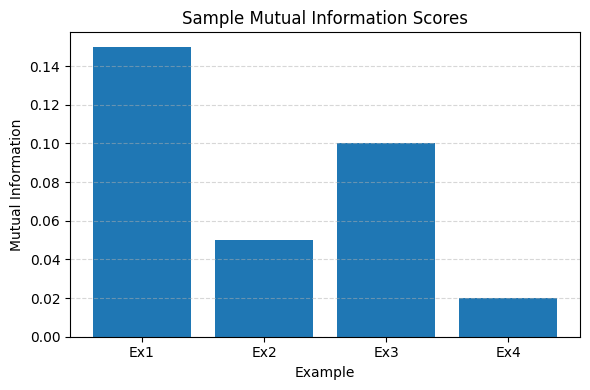

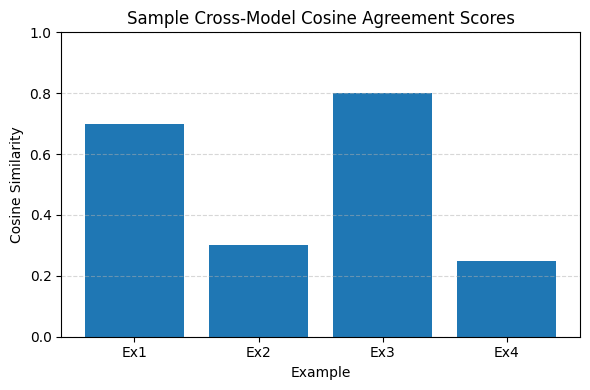

In [28]:
import matplotlib.pyplot as plt

# ─── Replace these with your real example labels ───
example_labels = ["Ex1", "Ex2", "Ex3", "Ex4"]

# ─── Replace the following with your computed MI scores ───
mi_scores = [0.15, 0.05, 0.10, 0.02]

# ─── Replace the following with your computed agreement scores (cosine sim) ───
agreement_scores = [0.70, 0.30, 0.80, 0.25]

# ─── Plot: Mutual Information ───
plt.figure(figsize=(6, 4))
plt.bar(range(len(mi_scores)), mi_scores, tick_label=example_labels)
plt.title("Sample Mutual Information Scores")
plt.xlabel("Example")
plt.ylabel("Mutual Information")
plt.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# ─── Plot: Cross‐Model Agreement ───
plt.figure(figsize=(6, 4))
plt.bar(range(len(agreement_scores)), agreement_scores, tick_label=example_labels)
plt.title("Sample Cross‐Model Cosine Agreement Scores")
plt.xlabel("Example")
plt.ylabel("Cosine Similarity")
plt.ylim(0, 1)  # Cosine similarity ranges from 0 to 1
plt.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
